# Initial setup (Always run)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
import pathlib
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from keras.applications.mobilenet import preprocess_input
import torch
import torchvision

2.17.0


# Preprocessing 

In [17]:
tsinghua_image_path = os.getcwd()+'/dog_classes'

Define different preprocessing functions

In [4]:
# Function to load and preprocess a single image
# Image is resized, converted to array, and normalised
def parse_image(image_path, target_size=(224, 224)):
    # Load and decode the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)  # Convert to array (height, width, channels)

    # Normalize to [0, 1]
    image /= 255.0  # Normalization is often necessary for model training
  
    return image

# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(image_paths):
    total_sum = np.zeros(3)  # We split into 3, to calculate the pr channel mean - good for deep learning models
    total_count = 0

    for img_path in image_paths:

        full_img_path = os.path.join(tsinghua_image_path, img_path)  # Join the base path with the image path

        parsed_img = parse_image(full_img_path, target_size=(224, 224))

        total_sum += np.mean(parsed_img, axis=(0, 1))  # Mean over width, height for each channel -> we only calculate the mean over the one picture here
        total_count += 1

    dataset_mean = total_sum / total_count
    return dataset_mean

# Compute the feature wise mean (over the whole dataset)
#dataset_mean = compute_dataset_mean(df['Image path'].tolist())
#print("Feature wise Mean: ", dataset_mean)

# Function to apply feature-wise centering
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Load images into the DataFrame and apply zero-centering
def load_images_into_dataframe(df, dataset_mean):
    # Create a list to hold the processed images
    images = []

    for image_path in df['Image path']:
        full_image_path = os.path.join("dog_classes/", image_path)
        #print(full_image_path)
        image_array = parse_image(full_image_path)  # Load and preprocess the image - is array
        image = zero_centering(image_array, dataset_mean)  # Apply zero centering
        #image /= 255.0
        images.append(image)  # Append the processed image to the list

    # Add the images as a new column in the DataFrame
    df.insert(2, 'Image', images)

    return df

# Load images into the DataFrame
#df = load_images_into_dataframe(df, dataset_mean)

# Now the DataFrame contains paths, labels, and processed images
#df.head(5)


# Visualize data

In [39]:
tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

print('Number of dog breeds: ', len(classes))

#Make empty array to save info about dog breeds and their frequencies
class_names_and_frequencies = []

#Loop through all classes
for class_name in classes:
    class_path = os.path.join(tsinghua_image_path, class_name)
    
    if class_name.startswith('.'):
        print(f"Skipping hidden file: {class_name}")
        continue
    
    dog_name = class_name.split('-')[2] #We only want after the second occurence of "-" in the directory name
    
    
    dog_frequency = len(os.listdir(class_path))
    class_names_and_frequencies.append((dog_name, dog_frequency))

#Get the dataframe
df = pd.DataFrame(class_names_and_frequencies, columns = ['Breeds', 'Frequency'])
print('Total number of images :', df['Frequency'].sum())

Number of dog breeds:  130
Total number of images : 70432


In [40]:
#Check if it looks alright
df.head()

,Breeds,Frequency
0,Shiba_Dog,1043
1,French_bulldog,1121
2,Siberian_husky,1160
3,malamute,1324
4,Pomeranian,1936


NameError: name 'df' is not defined

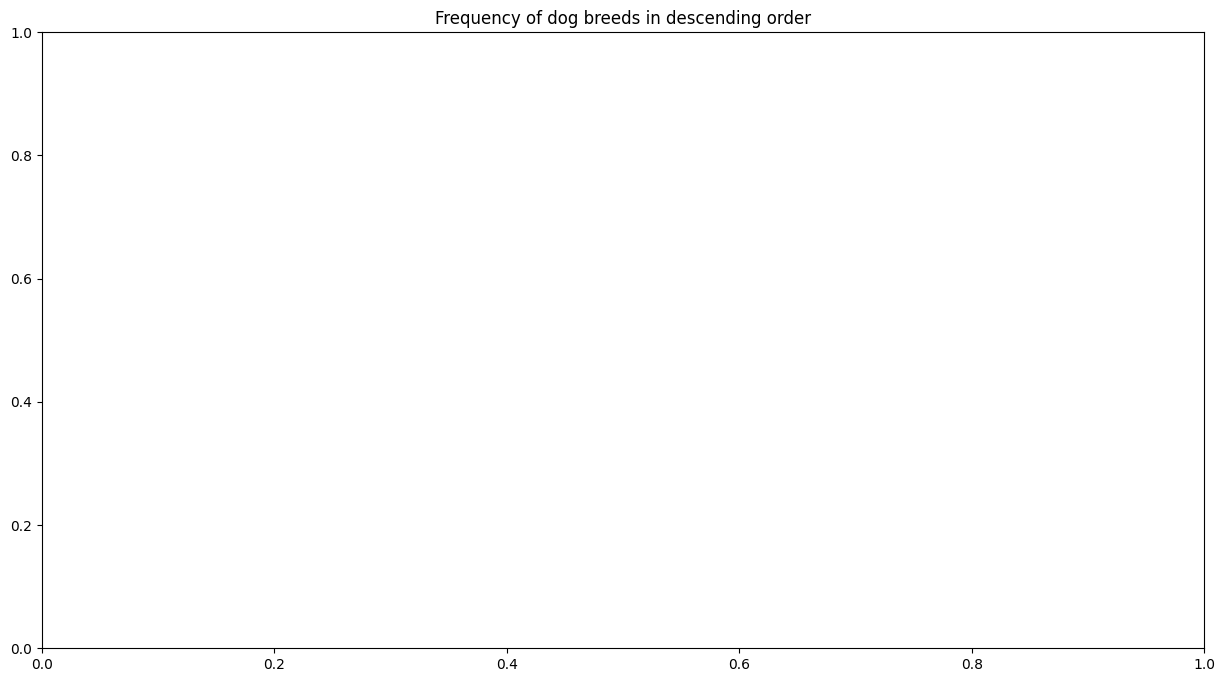

In [6]:
#Plot the distribution of dog breeds
plt.figure(figsize=(15,8))
plt.title('Frequency of dog breeds in descending order')
sns.barplot(x = 'Frequency', y = 'Breeds', data = df.sort_values('Frequency', ascending = False).head(30))

# Preprocessing

Here we load images of (currently 5 classes) into a data frame and apply zero-centering

In [7]:
#Array containing all data
dogs = []

tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

#classes = classes[:2]
classes = ['5355-n000126-golden_retriever', '7449-n000128-teddy']
print("Number of classes to consider: ", len(classes))
paths = [] 
classes_2 = []

for dog_breed in classes:
    if dog_breed.startswith('.'):
        print(f"Skipping hidden file: {dog_breed}")
        continue
    dog_breed_path = os.path.join(tsinghua_image_path, dog_breed)
    for image_id in os.listdir(dog_breed_path):
        path = os.path.join(dog_breed_path, image_id)
        label = dog_breed.split('-')[2]
        dogs.append((path, label))
        paths.append(path)
        classes_2.append(label)

df = pd.DataFrame(dogs, columns = ['Image path', 'Label'])
#print('Shape of dataframe :', df.shape)
print(len(classes_2))
print(len(paths))
df.head()

Number of classes to consider:  2
12804
12804


,Image path,Label
0,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,golden_retriever
1,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,golden_retriever
2,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,golden_retriever
3,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,golden_retriever
4,c:\GitRepository\Dog-Breed-Classifier/dog_clas...,golden_retriever


In [9]:
# Compute the dataset mean
data_mean = compute_dataset_mean(df['Image path'].tolist())
print("Dataset Mean: ", data_mean)

# Make dataframe by applying the mean to zero-center 
df_with_images = load_images_into_dataframe(df, data_mean)

# Now the DataFrame contains paths, labels, and processed images
df.head(5)

NameError: name 'compute_dataset_mean' is not defined

# Train, validation, and test split

Now we can split the Dataframe, `df`, that contains all our data into training, validation and test sets

In [4]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df,
                                                                            target = 'Label',
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

# Reset the indices of the different sets
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [5]:
# Print the dataset sizes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(7682, 1) (7682,)
(2561, 1) (2561,)
(2561, 1) (2561,)


In [6]:
X_train.head(10)

,Image path
0,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
1,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
2,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
3,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
4,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
5,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
6,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
7,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
8,c:\GitRepository\Dog-Breed-Classifier/dog_clas...
9,c:\GitRepository\Dog-Breed-Classifier/dog_clas...


# Model training

Train a basic model

In [8]:
import certifi
print(certifi.where())

c:\Users\theah\AppData\Local\Programs\Python\Python311\Lib\site-packages\certifi\cacert.pem


Load convolutional base

In [10]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

Create a new top layer and add it to the conv base

In [11]:
#Number of classes
N=2

# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Make convolutional layers "untrainable" such that we only train the decoder

In [12]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [46]:
# Create an ImageDataGenerator instance
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
directory = os.getcwd() + '/dog_classes'

selected_classes = ['5355-n000126-golden_retriever', '7449-n000128-teddy']

# Using flow_from_dataframe with ImageDataGenerator
train_generator_2 = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image path',              # Column containing file paths
    y_col='Label',                 # Column containing labels
    target_size=(224, 224),         # Resize images to this size
    batch_size=8,
    class_mode='categorical',       # Set to 'categorical' for multi-class labels
    subset='training',              # Define subset as 'training'
    shuffle=True
)

validation_generator_2 = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'             # Define subset as 'validation'
)

""" train_generator_2 = datagen.flow_from_directory(
    directory=directory,
    classes=selected_classes,
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator_2 = datagen.flow_from_directory(
    directory=directory,
    classes=selected_classes,
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    shuffle=True
) """

Found 10244 validated image filenames belonging to 2 classes.
Found 2560 validated image filenames belonging to 2 classes.


" train_generator_2 = datagen.flow_from_directory(\n    directory=directory,\n    classes=selected_classes,\n    target_size=(224,224),\n    batch_size=8,\n    class_mode='categorical',\n    subset='training',\n    shuffle=True\n)\n\nvalidation_generator_2 = datagen.flow_from_directory(\n    directory=directory,\n    classes=selected_classes,\n    target_size=(224,224),\n    batch_size=8,\n    class_mode='categorical',\n    subset='validation',\n    shuffle=True\n) "

In [53]:
# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
#sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)

sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator_2.n//train_generator_2.batch_size # Number of mini-batches per epoch (training)
print('Train step size: ', step_size_train)
step_size_val = validation_generator_2.n//validation_generator_2.batch_size # Number of mini-batches per epoch (validation)
print('Validation step size: ', step_size_val)

#These are from the preprocessing section
data = paths
labels = classes_2

# Train model for 10 epochs
history = model.fit(data,
                   labels,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   shuffle = True,
                   batch_size=8,
                   epochs=10)

Train step size:  1280
Validation step size:  320


ValueError: Unrecognized data type: x=['c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155761.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155762.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155763.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155764.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155765.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155766.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155767.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155768.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155769.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155770.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155771.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155772.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155773.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155774.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155775.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155776.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155777.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155778.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155779.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155780.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155781.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155782.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155783.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155784.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155785.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155786.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155787.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155788.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155789.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155790.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155791.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155792.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155793.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155794.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155795.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155796.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155797.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155798.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155799.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155800.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155801.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155802.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155803.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155804.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155805.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155806.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155807.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155808.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155809.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155810.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155811.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155812.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155813.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155814.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155815.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155816.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155817.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155818.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155819.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155820.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155821.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155822.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155823.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155824.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155825.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155826.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155827.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155828.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155829.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155830.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155831.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155832.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155833.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155834.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155835.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155836.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155837.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155838.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155839.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155840.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155841.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155842.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155843.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155844.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155845.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155846.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155847.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155848.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155849.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155850.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155851.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155852.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155853.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155854.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155855.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155856.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155857.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155858.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155859.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155860.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155861.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155862.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155863.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155864.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155865.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155866.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155867.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155868.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155869.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155870.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155871.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155872.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155873.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155874.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155875.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155876.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155877.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155878.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155879.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155880.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155881.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155882.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155883.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155884.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155885.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155886.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155887.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155888.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155889.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155890.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155891.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155892.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155893.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155894.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155895.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155896.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155897.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155898.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155899.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155900.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155901.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155905.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155906.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155907.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155908.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155909.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155910.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155911.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155912.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155913.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155914.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155915.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155916.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155917.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155918.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155919.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155920.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155921.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155922.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155923.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155924.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155925.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155926.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155927.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155928.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155929.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155930.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155931.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155932.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155933.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155934.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155935.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155936.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155937.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155938.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155939.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155940.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155941.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155942.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155943.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155944.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155945.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155946.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155947.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155948.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155955.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155956.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155957.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155958.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155959.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155960.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155961.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155962.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155966.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155967.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155968.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155970.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155971.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155972.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155975.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155976.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155977.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155978.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155979.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155980.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155981.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155982.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155983.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155984.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155985.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155986.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155987.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155988.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155989.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155990.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155991.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155995.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155996.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155997.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n155999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156001.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156002.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156003.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156004.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156005.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156006.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156007.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156008.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156009.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156010.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156011.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156012.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156013.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156014.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156015.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156016.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156017.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156018.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156019.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156022.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156023.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156024.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156025.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156026.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156027.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156031.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156032.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156033.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156034.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156035.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156036.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156037.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156038.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156039.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156040.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156041.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156042.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156043.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156044.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156045.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156046.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156048.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156049.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156050.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156056.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156057.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156058.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156062.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156063.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156064.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156065.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156066.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156067.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156068.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156069.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156070.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156071.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156072.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156073.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156077.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156078.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156079.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156080.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156081.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156082.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156086.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156087.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156088.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156089.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156090.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156091.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156092.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156097.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156100.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156101.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156102.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156103.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156104.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156105.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156106.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156107.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156111.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156112.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156113.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156115.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156116.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156117.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156118.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156121.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156122.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156125.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156126.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156127.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156131.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156132.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156133.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156134.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156135.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156136.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156137.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156138.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156139.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156140.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156141.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156142.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156143.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156144.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156145.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156146.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156147.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156148.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156149.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156150.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156151.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156152.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156153.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156154.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156155.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156156.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156157.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156158.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156159.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156160.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156161.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156162.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156163.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156165.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156166.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156167.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156168.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156169.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156170.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156171.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156172.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156181.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156182.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156183.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156185.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156186.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156187.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156188.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156189.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156190.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156191.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156192.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156193.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156202.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156203.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156204.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156207.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156208.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156209.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156213.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156214.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156215.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156216.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156217.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156218.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156219.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156220.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156224.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156225.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156226.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156230.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156231.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156232.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156233.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156234.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156235.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156236.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156237.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156238.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156240.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156243.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156244.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156245.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156247.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156253.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156254.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156255.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156256.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156257.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156259.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156260.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156263.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156264.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156265.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156277.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156278.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156279.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156285.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156286.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156287.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156291.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156292.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156293.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156294.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156295.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156296.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156300.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156301.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156302.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156303.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156304.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156305.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156306.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156307.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156308.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156309.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156310.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156311.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156312.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156313.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156314.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156315.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156318.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156319.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156320.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156321.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156322.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156323.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156324.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156325.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156329.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156330.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156331.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156332.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156333.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156334.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156338.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156339.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156340.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156344.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156345.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156346.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156350.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156351.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156352.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156353.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156354.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156355.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156356.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156357.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156358.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156359.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156360.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156361.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156362.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156363.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156364.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156368.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156369.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156370.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156377.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156378.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156379.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156380.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156381.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156382.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156386.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156387.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156388.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156389.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156390.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156391.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156392.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156393.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156394.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156395.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156396.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156398.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156399.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156400.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156401.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156410.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156411.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156412.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156413.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156414.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156415.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156417.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156418.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156419.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156423.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156424.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156425.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156426.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156427.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156428.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156429.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156430.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156431.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156439.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156440.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156442.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156444.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156445.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156446.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156447.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156448.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156449.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156450.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156451.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156452.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156453.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156454.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156455.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156456.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156457.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156458.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156459.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156460.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156464.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156465.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156466.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156467.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156468.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156469.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156476.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156477.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156478.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156479.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156480.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156481.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156482.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156483.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156484.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156499.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156500.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156501.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156502.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156503.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156504.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156511.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156512.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156513.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156514.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156516.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156519.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156530.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156531.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156532.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156539.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156540.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156541.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156542.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156543.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156544.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156545.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156546.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156547.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156548.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156549.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156553.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156554.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156555.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156556.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156557.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156558.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156559.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156560.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156561.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156562.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156563.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156564.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156565.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156572.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156573.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156574.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156575.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156576.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156577.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156578.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156579.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156580.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156581.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156582.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156586.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156587.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156588.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156592.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156593.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156594.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156595.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156596.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156597.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156598.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156599.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156600.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156601.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156602.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156603.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156604.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156605.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156607.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156613.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156614.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156615.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156619.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156620.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156621.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156622.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156623.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156624.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156625.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156626.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156627.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156631.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156632.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156633.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156634.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156635.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156636.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156637.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156638.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156639.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156643.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156644.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156645.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156649.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156650.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156651.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156652.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156656.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156657.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156658.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156659.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156660.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156661.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156665.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156666.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156667.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156670.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156671.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156672.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156673.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156674.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156675.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156676.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156677.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156678.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156681.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156686.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156687.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156688.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156689.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156690.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156691.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156695.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156696.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156697.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156704.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156705.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156706.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156707.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156708.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156709.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156710.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156714.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156715.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156716.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156717.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156718.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156719.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156720.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156721.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156725.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156726.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156727.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156730.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156731.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156732.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156734.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156735.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156736.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156737.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156738.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156739.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156740.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156741.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156742.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156743.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156744.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156745.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156746.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156747.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156748.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156749.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156750.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156751.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156752.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156753.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156754.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156755.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156756.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156757.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156758.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156759.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156760.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156761.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156762.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156763.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156767.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156768.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156769.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156770.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156771.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156772.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156773.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156778.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156779.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156780.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156781.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156782.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156783.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156787.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156788.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156789.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156790.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156791.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156792.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156793.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156794.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156795.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156796.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156797.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156798.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156799.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156800.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156801.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156802.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156803.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156804.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156805.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156806.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156807.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156808.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156809.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156810.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156811.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156812.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156813.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156814.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156815.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156816.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156817.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156818.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156819.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156820.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156830.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156831.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156832.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156833.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156834.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156835.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156836.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156837.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156838.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156839.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156840.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156841.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156842.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156843.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156844.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156850.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156851.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156852.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156853.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156854.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156855.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156856.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156857.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156858.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156859.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156860.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156861.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156862.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156863.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156864.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156865.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156866.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156867.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156871.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156872.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156873.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156874.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156875.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156877.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156879.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156881.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156882.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156883.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156884.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156885.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156886.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156887.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156888.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156889.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156890.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156891.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156892.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156893.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156895.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156896.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156897.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156898.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156899.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156900.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156901.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156902.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156903.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156904.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156905.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156906.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156907.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156908.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156909.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156910.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156911.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156912.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156923.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156924.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156925.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156926.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156927.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156928.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156929.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156930.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156931.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156935.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156936.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156937.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156938.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156939.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156940.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156944.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156945.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156946.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156950.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156951.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156955.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156956.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156957.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156958.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156959.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156960.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156961.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156962.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156963.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156964.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156965.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156966.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156970.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156971.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156972.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156973.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156974.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156975.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156982.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156983.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156984.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156985.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156986.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156987.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156988.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156989.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156990.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156997.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156998.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n156999.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157006.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157007.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157008.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157009.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157010.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157011.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157012.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157013.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157014.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157015.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157016.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157017.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157018.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157019.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157020.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157024.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157025.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157026.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157027.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157028.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157029.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157036.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157037.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157038.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157039.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157040.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157041.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157042.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157043.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157044.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157045.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157046.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157047.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157048.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157049.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157050.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157051.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157052.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157054.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157056.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157059.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157060.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157061.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157064.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157065.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157066.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157067.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157068.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157069.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157070.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157071.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157075.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157076.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157077.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157078.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157079.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157080.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157084.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157085.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157086.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157089.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157090.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157091.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157092.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157093.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157094.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157095.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157096.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157097.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157098.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157099.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157100.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157104.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157105.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157106.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157107.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157108.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157109.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157110.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157117.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157118.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157119.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157120.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157121.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157122.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157123.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157124.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157125.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157126.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157127.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157128.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157129.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157130.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157131.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157132.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157133.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157134.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157135.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157136.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157137.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157138.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157139.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157140.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157141.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157142.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157143.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157144.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157148.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157149.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157150.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157151.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157152.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157153.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157154.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157155.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157156.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157157.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157158.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157159.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157166.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157167.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157168.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157172.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157173.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157174.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157175.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157176.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157177.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157178.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157182.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157183.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157184.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157185.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157186.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157187.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157191.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157192.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157193.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157203.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157204.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157205.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157209.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157210.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157211.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157212.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157213.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157214.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157217.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157218.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157219.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157220.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157221.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157222.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157223.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157224.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157225.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157226.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157227.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157228.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157229.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157230.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157231.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157232.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157233.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157234.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157235.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157236.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157240.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157241.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157242.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157243.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157245.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157246.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157247.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157248.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157249.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157250.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157254.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157255.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157256.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157259.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157260.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157261.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157262.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157263.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157264.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157265.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157266.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157267.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157268.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157269.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157270.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157273.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157274.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157275.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157276.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157277.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157278.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157279.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157280.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157284.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157285.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157286.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157287.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157288.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157289.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157294.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157295.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157296.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157297.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157298.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157299.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157300.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157301.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157302.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157303.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157304.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157308.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157309.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157310.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157311.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157312.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157313.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157314.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157315.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157316.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157317.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157318.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157319.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157320.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157321.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157322.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157323.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157324.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157325.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157326.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157327.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157328.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157329.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157330.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157336.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157337.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157338.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157339.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157340.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157341.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157342.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157343.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157344.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157345.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157346.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157347.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157351.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157352.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157353.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157357.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157358.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157359.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157360.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157361.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157362.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157363.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157364.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157368.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157369.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157370.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157371.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157372.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157373.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157374.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157375.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157382.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157383.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157384.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157385.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157386.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157387.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157388.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157389.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157390.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157391.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157392.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157393.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157394.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157395.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157396.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157397.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157398.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157399.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157400.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157401.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157402.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157403.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157404.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157405.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157406.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157407.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157408.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157409.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157410.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157411.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157418.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157419.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157420.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157421.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157422.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157423.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157427.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157428.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157429.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157430.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157431.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157432.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157433.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157434.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157435.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157445.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157446.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157447.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157448.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157449.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157450.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157451.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157452.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157456.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157457.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157458.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157462.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157463.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157464.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157465.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157466.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157467.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157469.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157470.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157471.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157472.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157473.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157474.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157475.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157476.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157477.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157481.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157482.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157483.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157484.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157485.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157486.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157490.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157491.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157492.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157493.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157494.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157495.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157496.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157497.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157498.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157499.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157503.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157504.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157505.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157506.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157507.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157508.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157509.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157510.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157511.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157512.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157513.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157514.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157515.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157516.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157517.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157518.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157520.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157521.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157522.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157523.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157524.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157525.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157526.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157527.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157528.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157529.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157530.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157531.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157532.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157533.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157537.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157538.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157539.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157540.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157541.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157542.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157543.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157544.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157546.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157547.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157548.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157552.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157553.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157554.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157555.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157563.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157564.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157565.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157569.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157570.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157571.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157572.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157573.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157574.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157575.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157576.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157580.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157581.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157588.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157589.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157590.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157591.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157592.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157593.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157597.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157598.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157599.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157600.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157601.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157602.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157615.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157616.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157617.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157618.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157619.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157620.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157621.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157622.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157623.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157631.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157632.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157636.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157637.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157638.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157639.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157640.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157641.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157642.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157643.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157644.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157648.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157649.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157650.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157651.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157652.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157653.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157654.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157655.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157656.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157657.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157658.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157659.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157660.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157661.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157662.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157663.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157664.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157671.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157672.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157673.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157674.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157675.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157676.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157677.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157678.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157684.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157685.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157686.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157693.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157694.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157695.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157696.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157697.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157705.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157706.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157707.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157714.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157715.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157716.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157717.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157718.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157719.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157720.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157721.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157722.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157723.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157724.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157725.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157729.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157730.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157731.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157733.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157734.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157735.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157739.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157740.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157741.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157745.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157746.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157747.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157748.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157749.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157750.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157754.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157755.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157756.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157763.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157764.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157765.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157766.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157767.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157768.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157775.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157776.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157777.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157778.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157785.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157789.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157790.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157791.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157795.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157796.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157797.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157798.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157799.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157800.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157801.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157802.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157803.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157804.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157805.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157806.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157807.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157808.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157809.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157810.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157811.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157812.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157822.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157823.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157824.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157825.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157826.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157827.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157831.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157832.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157833.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157834.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157835.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157836.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157840.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157841.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157842.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157843.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157844.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157845.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157846.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157847.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157848.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157855.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157856.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157859.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157860.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157861.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157862.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157863.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157864.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157889.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157890.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157891.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157892.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157893.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157894.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157895.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157896.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157907.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157908.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157909.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157918.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157919.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157920.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157921.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157922.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157923.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157941.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157942.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157943.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157944.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157945.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157946.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157951.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157952.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157954.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157964.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157965.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157966.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n157999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158001.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158004.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158005.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158012.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158016.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158017.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158021.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158022.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158023.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158024.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158025.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158026.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158033.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158034.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158035.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158039.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158040.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158062.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158080.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158081.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158130.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158131.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158132.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158155.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158156.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158157.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158173.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158174.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158175.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158176.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158177.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158178.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158179.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158180.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158181.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158182.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158183.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158184.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158187.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158188.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158189.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158190.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158191.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158192.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158199.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158200.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158201.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158205.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158206.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158207.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158220.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158221.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158222.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158229.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158230.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158233.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158250.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158251.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158252.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158253.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158254.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158258.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158260.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158261.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158262.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158263.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158264.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158265.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158266.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158267.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158268.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158269.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158270.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158271.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158272.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158273.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158274.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158275.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158276.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158277.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158278.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158279.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158280.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158281.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158282.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158283.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158284.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158285.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158286.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158287.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158288.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158289.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158290.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158291.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158296.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158297.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158298.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158299.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158300.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158301.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158305.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158306.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158307.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158308.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158309.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158310.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158311.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158312.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158313.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158317.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158318.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158319.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158326.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158327.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158329.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158330.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158331.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158333.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158338.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158339.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158340.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158344.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158345.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158346.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158347.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158348.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158349.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158351.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158352.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158353.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158354.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158355.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158357.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158358.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158359.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158360.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158362.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158363.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158364.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158368.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158369.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158370.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158371.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158372.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158373.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158375.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158376.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158377.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158390.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158391.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158392.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158393.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158394.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158395.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158396.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158397.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158398.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158403.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158404.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158405.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158417.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158418.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158419.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158421.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158422.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158423.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158427.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158428.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158429.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158430.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158434.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158435.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158436.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158437.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158438.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158445.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158446.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158447.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158450.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158451.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158452.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158456.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158457.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158461.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158462.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158463.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158464.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158465.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158466.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158470.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158471.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158472.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158473.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158474.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158480.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158481.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158482.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158483.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158484.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158485.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158486.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158487.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158488.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158503.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158504.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158505.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158506.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158507.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158508.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158509.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158510.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158511.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158521.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158522.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158523.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158524.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158525.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158526.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158529.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158530.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158531.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158532.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158536.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158537.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158538.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158539.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158540.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158541.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158547.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158548.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158549.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158552.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158553.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158554.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158564.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158565.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158566.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158567.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158568.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158569.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158570.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158571.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158572.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158576.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158577.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158578.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158579.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158580.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158581.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158583.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158584.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158585.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158586.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158591.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158592.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158593.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158594.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158595.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158598.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158599.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158600.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158601.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158605.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158606.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158607.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158608.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158609.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158610.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n158999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159187.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n159999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160187.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n160999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\5355-n000126-golden_retriever\\n161139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161703.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161704.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161705.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161706.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161707.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161708.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161712.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161713.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161714.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161721.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161722.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161723.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161724.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161725.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161726.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161727.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161728.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161729.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161730.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161734.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161735.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161736.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161740.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161741.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161748.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161749.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161750.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161760.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161761.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161762.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161763.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161764.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161765.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161766.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161780.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161781.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161782.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161783.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161784.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161785.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161786.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161787.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161788.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161789.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161790.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161791.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161792.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161793.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161800.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161801.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161802.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161803.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161804.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161805.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161815.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161816.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161817.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161818.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161819.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161826.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161827.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161828.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161829.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161830.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161836.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161837.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161838.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161839.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161840.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161841.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161842.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161843.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161844.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161848.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161855.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161856.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161857.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161858.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161859.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161860.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161861.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161862.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161863.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161867.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161871.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161872.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161873.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161877.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161878.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161879.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161880.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161881.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161884.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161885.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161886.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161887.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161890.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161891.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161892.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161896.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161897.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161900.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161902.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161903.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161904.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161905.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161906.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161908.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161909.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161910.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161911.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161912.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161916.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161917.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161918.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161919.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161920.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161924.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161925.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161926.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161927.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161928.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161932.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161942.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161943.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161944.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161945.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161946.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161947.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161948.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161949.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161950.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161951.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161952.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161954.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161956.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161957.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161958.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161959.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161960.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161963.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161964.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161965.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161966.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161970.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161971.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161972.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161974.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161976.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161977.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161979.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161980.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161981.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161984.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161985.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161986.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161987.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161988.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161989.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161997.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161998.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n161999.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162003.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162004.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162008.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162010.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162011.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162021.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162022.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162025.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162028.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162029.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162030.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162031.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162032.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162033.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162034.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162043.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162044.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162045.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162046.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162047.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162048.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162049.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162050.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162051.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162052.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162053.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162054.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162055.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162063.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162064.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162065.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162068.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162069.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162070.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162071.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162072.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162073.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162076.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162078.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162082.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162083.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162084.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162097.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162098.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162099.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162101.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162102.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162103.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162104.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162105.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162106.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162107.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162110.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162111.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162112.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162118.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162119.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162120.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162121.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162122.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162123.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162124.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162125.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162129.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162130.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162131.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162132.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162137.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162138.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162139.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162140.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162141.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162142.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162143.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162144.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162161.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162162.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162163.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162164.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162165.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162166.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162167.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162168.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162169.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162170.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162171.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162173.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162175.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162176.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162177.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162178.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162179.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162180.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162181.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162182.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162183.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162184.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162185.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162186.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162187.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162196.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162197.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162201.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162202.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162208.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162209.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162210.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162214.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162215.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162216.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162217.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162218.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162219.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162220.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162221.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162222.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162223.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162224.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162225.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162226.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162227.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162228.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162229.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162236.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162237.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162238.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162245.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162246.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162247.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162253.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162254.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162263.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162264.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162267.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162268.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162270.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162271.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162272.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162273.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162274.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162275.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162282.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162283.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162289.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162290.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162291.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162292.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162293.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162294.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162295.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162296.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162297.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162298.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162299.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162300.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162301.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162302.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162303.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162307.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162308.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162309.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162314.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162315.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162316.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162317.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162318.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162319.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162320.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162321.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162322.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162323.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162330.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162331.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162332.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162339.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162340.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162341.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162342.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162343.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162344.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162345.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162351.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162353.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162356.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162358.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162359.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162360.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162361.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162362.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162363.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162373.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162374.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162375.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162376.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162377.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162381.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162382.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162383.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162384.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162386.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162388.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162389.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162393.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162397.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162398.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162399.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162400.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162401.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162402.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162403.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162407.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162408.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162409.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162410.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162411.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162412.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162413.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162424.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162425.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162426.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162427.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162428.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162429.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162433.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162434.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162435.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162436.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162437.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162439.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162468.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162469.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162470.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162485.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162486.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162487.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162488.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162489.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162490.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162509.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162510.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162511.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162512.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162513.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162514.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162517.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162518.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162519.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162520.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162521.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162522.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162526.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162527.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162530.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162559.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162591.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162592.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162593.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162601.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162602.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162603.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162607.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162608.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162609.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162610.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162614.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162615.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162616.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162617.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162618.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162620.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162621.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162627.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162637.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162667.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162668.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162669.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162670.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162671.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162672.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162713.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162722.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162723.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162726.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162735.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162737.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162738.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162760.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162764.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162768.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162769.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162793.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162794.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162795.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162869.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162870.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162871.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162895.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162899.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162917.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162918.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162919.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162921.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162922.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162923.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162928.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162929.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162930.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162932.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162934.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162937.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162938.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162939.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162940.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162953.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162954.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162955.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162982.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162983.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162984.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162988.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n162999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163001.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163002.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163003.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163006.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163007.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163008.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163013.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163014.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163015.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163024.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163025.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163026.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163037.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163041.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163047.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163052.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163053.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163054.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163058.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163059.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163060.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163061.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163070.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163106.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163107.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163116.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163125.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163126.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163127.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163128.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163135.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163136.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163137.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163138.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163139.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163140.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163148.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163149.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163150.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163151.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163152.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163153.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163154.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163155.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163156.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163157.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163158.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163159.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163163.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163167.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163177.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163178.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163179.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163180.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163182.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163183.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163185.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163186.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163187.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163189.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163190.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163194.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163195.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163196.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163197.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163198.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163199.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163200.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163201.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163202.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163203.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163204.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163208.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163209.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163210.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163211.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163212.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163213.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163215.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163216.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163217.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163218.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163222.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163224.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163226.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163228.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163229.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163230.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163231.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163232.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163234.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163238.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163239.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163240.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163241.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163245.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163246.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163247.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163248.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163249.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163250.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163251.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163252.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163253.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163254.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163255.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163256.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163260.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163262.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163264.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163269.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163270.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163271.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163272.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163275.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163276.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163277.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163278.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163280.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163283.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163288.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163289.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163290.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163291.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163292.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163295.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163296.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163297.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163298.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163299.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163300.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163301.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163302.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163303.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163304.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163305.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163306.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163307.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163314.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163315.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163316.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163317.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163318.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163319.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163320.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163321.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163322.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163323.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163324.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163328.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163331.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163332.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163333.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163334.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163338.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163343.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163344.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163358.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163359.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163360.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163361.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163365.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163369.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163370.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163371.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163372.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163373.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163374.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163377.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163378.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163379.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163386.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163387.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163388.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163389.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163390.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163391.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163393.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163394.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163395.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163398.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163399.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163400.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163401.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163402.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163403.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163405.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163406.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163407.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163409.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163412.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163413.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163422.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163423.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163424.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163426.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163427.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163428.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163435.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163436.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163437.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163442.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163443.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163444.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163456.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163457.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163458.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163459.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163460.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163461.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163462.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163463.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163464.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163468.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163469.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163470.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163471.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163472.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163473.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163474.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163475.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163476.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163479.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163480.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163484.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163487.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163491.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163492.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163501.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163502.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163503.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163504.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163505.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163506.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163509.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163511.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163512.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163513.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163515.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163516.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163518.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163519.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163520.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163521.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163522.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163523.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163524.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163525.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163526.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163527.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163528.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163529.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163531.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163533.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163534.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163535.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163536.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163537.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163538.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163539.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163540.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163541.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163543.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163544.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163548.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163552.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163553.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163554.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163555.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163565.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163566.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163573.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163574.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163575.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163576.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163578.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163579.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163580.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163583.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163584.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163588.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163589.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163590.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163591.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163592.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163593.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163596.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163597.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163598.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163599.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163600.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163607.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163608.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163609.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163610.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163611.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163612.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163613.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163616.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163617.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163618.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163619.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163620.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163621.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163634.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163636.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163637.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163638.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163639.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163640.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163641.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163642.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163647.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163648.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163649.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163650.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163651.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163652.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163653.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163654.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163656.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163658.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163659.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163660.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163661.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163662.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163663.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163664.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163665.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163668.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163669.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163672.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163673.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163674.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163686.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163687.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163688.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163692.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163693.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163694.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163695.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163696.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163697.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163703.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163704.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163705.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163709.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163710.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163717.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163718.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163719.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163720.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163721.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163722.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163723.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163724.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163725.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163726.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163727.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163728.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163734.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163735.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163736.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163740.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163741.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163742.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163743.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163744.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163745.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163747.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163748.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163749.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163750.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163751.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163752.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163753.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163754.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163755.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163756.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163757.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163758.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163759.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163760.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163761.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163762.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163763.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163764.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163767.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163768.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163769.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163770.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163771.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163772.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163773.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163777.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163778.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163779.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163780.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163781.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163782.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163783.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163784.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163785.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163786.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163787.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163788.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163789.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163790.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163791.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163792.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163793.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163794.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163798.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163799.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163800.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163801.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163802.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163803.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163804.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163805.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163806.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163807.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163808.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163809.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163810.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163811.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163812.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163813.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163816.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163818.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163819.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163822.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163823.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163824.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163826.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163827.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163828.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163829.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163830.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163833.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163834.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163835.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163836.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163837.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163838.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163839.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163840.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163841.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163842.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163843.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163844.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163845.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163846.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163847.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163848.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163849.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163850.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163851.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163854.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163855.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163856.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163857.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163861.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163862.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163863.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163864.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163865.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163866.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163867.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163868.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163874.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163875.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163876.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163877.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163878.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163879.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163880.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163881.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163882.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163883.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163884.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163885.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163887.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163888.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163889.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163891.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163892.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163893.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163894.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163895.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163896.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163899.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163900.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163901.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163907.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163908.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163909.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163911.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163912.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163915.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163916.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163917.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163925.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163926.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163927.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163928.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163929.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163937.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163938.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163939.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163940.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163941.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163942.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163943.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163944.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163945.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163946.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163947.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163950.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163952.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163954.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163955.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163956.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163957.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163958.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163959.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163960.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163961.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163962.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163963.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163966.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163967.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163971.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163972.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163973.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163977.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163978.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163979.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163986.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163987.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163988.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163989.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163990.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163991.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163992.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163993.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163994.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n163999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164017.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164018.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164019.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164020.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164021.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164025.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164026.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164027.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164028.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164029.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164030.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164034.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164035.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164036.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164040.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164041.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164042.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164046.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164047.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164048.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164049.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164050.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164051.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164052.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164053.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164056.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164057.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164058.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164059.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164060.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164064.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164067.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164068.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164069.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164073.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164074.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164075.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164076.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164077.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164078.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164079.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164080.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164081.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164082.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164083.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164084.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164085.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164086.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164087.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164088.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164089.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164090.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164091.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164092.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164093.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164094.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164095.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164096.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164097.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164098.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164099.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164100.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164101.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164102.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164103.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164105.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164106.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164107.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164108.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164110.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164112.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164113.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164117.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164118.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164119.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164123.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164124.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164125.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164129.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164130.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164131.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164135.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164136.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164137.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164138.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164139.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164140.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164141.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164142.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164143.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164145.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164146.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164149.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164150.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164157.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164158.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164159.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164160.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164161.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164162.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164163.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164164.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164165.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164166.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164167.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164168.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164169.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164173.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164174.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164175.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164179.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164180.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164181.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164184.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164185.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164186.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164187.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164190.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164191.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164192.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164193.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164197.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164199.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164200.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164201.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164202.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164203.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164204.jpg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n164999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165187.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n165999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166187.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n166999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167187.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n167999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168151.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168152.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168153.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168154.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168155.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168156.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168157.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168158.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168159.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168160.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168161.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168162.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168163.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168164.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168165.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168166.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168167.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168168.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168169.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168170.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168171.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168172.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168173.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168174.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168175.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168176.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168177.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168178.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168179.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168180.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168181.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168182.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168183.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168184.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168185.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168186.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168187.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168188.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168189.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168190.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168191.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168192.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168193.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168194.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168195.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168196.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168197.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168198.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168199.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168200.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168201.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168202.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168203.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168204.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168205.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168206.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168207.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168208.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168209.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168210.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168211.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168212.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168213.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168214.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168215.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168216.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168217.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168218.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168219.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168220.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168221.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168222.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168223.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168224.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168225.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168226.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168227.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168228.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168229.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168230.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168231.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168232.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168233.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168234.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168235.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168236.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168237.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168238.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168239.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168240.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168241.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168242.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168243.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168244.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168245.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168246.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168247.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168248.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168249.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168250.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168251.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168252.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168253.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168254.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168255.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168256.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168257.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168258.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168259.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168260.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168261.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168262.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168263.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168264.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168265.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168266.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168267.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168268.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168269.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168270.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168271.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168272.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168273.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168274.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168275.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168276.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168277.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168278.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168279.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168280.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168281.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168282.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168283.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168284.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168285.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168286.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168287.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168288.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168289.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168290.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168291.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168292.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168293.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168294.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168295.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168296.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168297.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168298.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168299.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168300.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168301.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168302.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168303.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168304.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168305.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168306.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168307.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168308.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168309.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168310.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168311.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168312.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168313.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168314.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168315.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168316.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168317.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168318.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168319.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168320.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168321.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168322.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168323.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168324.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168325.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168326.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168327.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168328.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168329.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168330.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168331.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168332.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168333.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168334.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168335.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168336.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168337.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168338.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168339.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168340.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168341.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168342.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168343.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168344.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168345.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168346.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168347.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168348.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168349.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168350.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168351.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168352.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168353.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168354.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168355.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168356.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168357.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168358.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168359.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168360.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168361.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168362.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168363.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168364.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168365.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168366.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168367.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168368.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168369.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168370.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168371.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168372.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168373.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168374.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168375.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168376.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168377.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168378.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168379.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168380.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168381.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168382.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168383.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168384.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168385.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168386.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168387.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168388.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168389.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168390.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168391.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168392.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168393.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168394.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168395.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168396.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168397.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168398.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168399.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168400.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168401.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168402.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168403.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168404.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168405.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168406.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168407.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168408.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168409.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168410.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168411.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168412.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168413.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168414.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168415.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168416.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168417.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168418.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168419.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168420.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168421.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168422.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168423.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168424.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168425.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168426.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168427.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168428.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168429.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168430.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168431.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168432.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168433.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168434.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168435.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168436.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168437.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168438.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168439.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168440.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168441.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168442.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168443.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168444.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168445.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168446.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168447.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168448.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168449.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168450.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168451.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168452.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168453.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168454.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168455.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168456.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168457.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168458.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168459.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168460.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168461.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168462.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168463.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168464.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168465.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168466.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168467.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168468.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168469.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168470.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168471.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168472.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168473.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168474.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168475.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168476.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168477.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168478.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168479.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168480.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168481.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168482.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168483.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168484.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168485.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168486.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168487.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168488.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168489.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168490.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168491.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168492.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168493.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168494.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168495.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168496.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168497.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168498.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168499.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168500.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168501.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168502.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168503.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168504.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168505.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168506.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168507.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168508.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168509.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168510.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168511.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168512.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168513.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168514.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168515.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168516.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168517.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168518.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168519.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168520.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168521.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168522.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168523.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168524.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168525.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168526.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168527.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168528.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168529.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168530.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168531.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168532.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168533.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168534.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168535.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168536.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168537.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168538.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168539.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168540.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168541.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168542.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168543.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168544.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168545.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168546.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168547.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168548.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168549.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168550.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168551.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168552.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168553.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168554.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168555.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168556.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168557.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168558.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168559.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168560.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168561.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168562.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168563.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168564.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168565.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168566.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168567.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168568.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168569.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168570.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168571.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168572.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168573.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168574.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168575.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168576.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168577.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168578.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168579.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168580.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168581.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168582.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168583.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168584.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168585.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168586.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168587.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168588.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168589.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168590.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168591.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168592.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168593.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168594.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168595.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168596.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168597.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168598.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168599.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168600.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168601.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168602.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168603.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168604.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168605.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168606.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168607.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168608.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168609.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168610.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168611.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168612.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168613.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168614.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168615.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168616.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168617.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168618.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168619.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168620.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168621.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168622.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168623.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168624.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168625.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168626.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168627.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168628.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168629.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168630.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168631.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168632.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168633.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168634.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168635.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168636.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168637.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168638.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168639.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168640.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168641.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168642.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168643.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168644.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168645.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168646.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168647.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168648.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168649.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168650.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168651.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168652.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168653.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168654.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168655.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168656.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168657.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168658.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168659.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168660.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168661.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168662.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168663.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168664.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168665.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168666.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168667.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168668.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168669.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168670.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168671.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168672.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168673.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168674.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168675.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168676.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168677.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168678.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168679.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168680.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168681.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168682.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168683.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168684.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168685.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168686.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168687.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168688.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168689.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168690.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168691.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168692.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168693.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168694.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168695.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168696.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168697.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168698.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168699.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168700.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168701.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168702.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168703.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168704.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168705.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168706.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168707.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168708.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168709.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168710.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168711.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168712.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168713.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168714.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168715.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168716.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168717.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168718.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168719.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168720.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168721.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168722.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168723.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168724.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168725.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168726.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168727.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168728.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168729.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168730.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168731.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168732.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168733.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168734.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168735.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168736.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168737.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168738.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168739.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168740.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168741.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168742.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168743.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168744.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168745.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168746.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168747.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168748.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168749.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168750.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168751.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168752.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168753.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168754.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168755.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168756.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168757.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168758.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168759.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168760.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168761.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168762.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168763.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168764.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168765.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168766.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168767.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168768.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168769.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168770.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168771.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168772.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168773.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168774.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168775.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168776.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168777.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168778.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168779.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168780.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168781.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168782.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168783.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168784.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168785.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168786.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168787.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168788.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168789.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168790.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168791.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168792.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168793.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168794.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168795.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168796.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168797.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168798.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168799.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168800.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168801.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168802.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168803.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168804.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168805.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168806.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168807.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168808.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168809.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168810.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168811.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168812.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168813.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168814.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168815.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168816.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168817.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168818.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168819.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168820.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168821.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168822.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168823.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168824.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168825.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168826.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168827.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168828.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168829.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168830.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168831.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168832.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168833.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168834.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168835.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168836.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168837.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168838.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168839.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168840.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168841.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168842.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168843.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168844.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168845.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168846.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168847.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168848.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168849.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168850.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168851.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168852.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168853.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168854.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168855.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168856.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168857.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168858.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168859.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168860.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168861.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168862.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168863.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168864.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168865.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168866.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168867.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168868.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168869.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168870.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168871.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168872.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168873.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168874.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168875.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168876.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168877.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168878.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168879.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168880.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168881.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168882.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168883.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168884.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168885.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168886.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168887.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168888.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168889.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168890.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168891.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168892.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168893.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168894.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168895.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168896.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168897.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168898.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168899.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168900.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168901.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168902.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168903.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168904.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168905.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168906.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168907.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168908.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168909.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168910.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168911.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168912.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168913.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168914.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168915.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168916.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168917.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168918.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168919.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168920.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168921.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168922.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168923.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168924.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168925.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168926.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168927.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168928.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168929.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168930.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168931.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168932.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168933.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168934.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168935.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168936.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168937.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168938.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168939.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168940.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168941.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168942.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168943.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168944.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168945.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168946.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168947.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168948.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168949.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168950.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168951.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168952.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168953.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168954.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168955.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168956.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168957.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168958.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168959.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168960.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168961.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168962.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168963.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168964.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168965.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168966.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168967.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168968.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168969.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168970.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168971.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168972.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168973.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168974.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168975.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168976.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168977.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168978.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168979.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168980.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168981.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168982.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168983.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168984.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168985.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168986.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168987.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168988.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168989.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168990.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168991.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168992.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168993.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168994.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168995.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168996.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168997.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168998.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n168999.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169000.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169001.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169002.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169003.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169004.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169005.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169006.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169007.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169008.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169009.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169010.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169011.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169012.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169013.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169014.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169015.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169016.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169017.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169018.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169019.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169020.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169021.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169022.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169023.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169024.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169025.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169026.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169027.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169028.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169029.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169030.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169031.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169032.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169033.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169034.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169035.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169036.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169037.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169038.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169039.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169040.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169041.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169042.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169043.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169044.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169045.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169046.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169047.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169048.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169049.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169050.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169051.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169052.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169053.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169054.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169055.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169056.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169057.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169058.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169059.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169060.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169061.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169062.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169063.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169064.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169065.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169066.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169067.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169068.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169069.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169070.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169071.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169072.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169073.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169074.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169075.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169076.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169077.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169078.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169079.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169080.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169081.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169082.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169083.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169084.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169085.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169086.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169087.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169088.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169089.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169090.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169091.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169092.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169093.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169094.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169095.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169096.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169097.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169098.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169099.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169100.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169101.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169102.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169103.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169104.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169105.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169106.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169107.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169108.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169109.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169110.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169111.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169112.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169113.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169114.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169115.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169116.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169117.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169118.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169119.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169120.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169121.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169122.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169123.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169124.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169125.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169126.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169127.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169128.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169129.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169130.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169131.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169132.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169133.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169134.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169135.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169136.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169137.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169138.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169139.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169140.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169141.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169142.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169143.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169144.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169145.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169146.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169147.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169148.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169149.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169150.jpeg', 'c:\\GitRepository\\Dog-Breed-Classifier/dog_classes\\7449-n000128-teddy\\n169151.jpeg'] (of type <class 'list'>)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


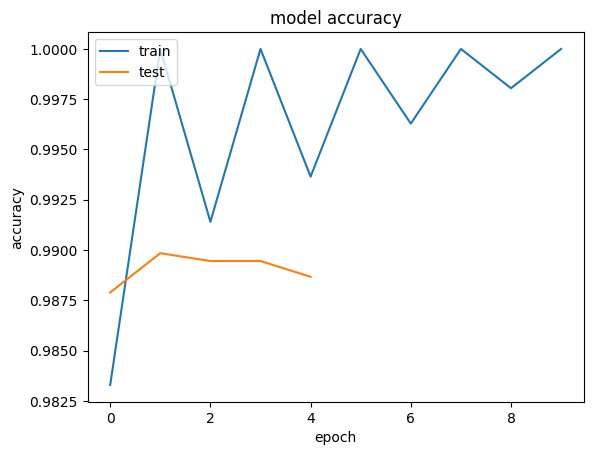

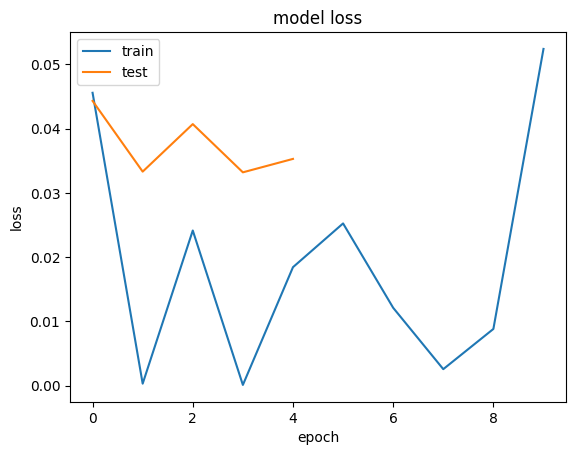

In [38]:
print(history.history.keys())
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Experiment

In [13]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df,
                                                                            target = 'Label',
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

# Reset the indices of the different sets
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
BATCH_SIZE = 8

epochs = 10
losses_df = {'train_loss' : [], 'val_loss' : [], 'val_acc' : []}
num_batches = len(X_train)//BATCH_SIZE
val_num_batches = len(X_valid)//BATCH_SIZE
best_loss = np.inf


device = torch.device('cuda')
mobilenet = model.to(device)

for epoch in range(epochs):
    print('Epoch :', epoch)
    scheduler.step(epoch)
    print('Learning rate :', get_lr(optimizer))
    print('Training for epoch {}'.format(epoch))
    val_outputs = []
    loss = 0
    vloss = 0
    
    mobilenet.train()
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        img, label = batch
        img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
        output = mobilenet(img)
        batch_loss = criterion(output, torch.max(label, 1)[1])
        batch_loss.backward()
        optimizer.step()
        loss +=batch_loss.item()
    
    train_loss = loss/num_batches
    print('Training loss for epoch {} is {:.4f}'.format(epoch, train_loss))
    losses_df['train_loss'].append(train_loss)
    print('Validation for epoch {}'.format(epoch))
    with torch.no_grad():
        mobilenet.eval()
    
        for i, batch in enumerate(val_loader):
            img, label = batch
            img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
            output = mobilenet(img)
            batch_loss = criterion(output, torch.max(label, 1)[1])
            output = output.detach().cpu().numpy()
            label = label.detach().cpu().numpy()
            val_outputs.extend(np.argmax(output, 1))
            vloss += batch_loss.item()
            
    val_loss = vloss/val_num_batches
    print('Validation loss for epoch {} is {:.4f}'.format(epoch, val_loss))
    losses_df['val_loss'].append(val_loss)
    val_labels = list(np.argmax(np.array(val_y), 1))
    acc = accuracy_score(val_outputs, val_labels)
    print('Accuracy for epoch {} is {:.4f}'.format(epoch, acc))
    losses_df['val_acc'].append(acc)
    
    if val_loss <= best_loss:
        print('Validation loss has reduced from {:.4f} to {:.4f}'.format(best_loss, val_loss))
        print('Saving model')
        best_loss = val_loss
        torch.save(mobilenet.state_dict(), 'alexnet_finetuning.pth')

AttributeError: 'Functional' object has no attribute 'to'

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
print(torch.cuda.is_available())
# 1. Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device.type)



# 2. Define Data Transformations for training and validation sets
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


traindataset = PlayingCardDataset(data_dir='/content/drive/MyDrive/cards2/train', transform=preprocess)
testdataset = PlayingCardDataset(data_dir='/content/drive/MyDrive/cards2/test', transform=preprocess)


# 3. Load datasets
# Assuming traindata_dir and testdata_dir are paths to your training and test data
trainloader = DataLoader(traindataset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testdataset, batch_size=128, shuffle=False, num_workers=2)

# Get dataset sizes
dataset_sizes = {
    'train': len(traindataset),
    'test': len(testdataset)
}
traindata_dir = "/content/drive/MyDrive/cards2/train"


# Get class names from the train dataset (assuming classes are the same in test)
#class_names = traindataset.labels  # Assuming your PlayingCardDataset has a 'labels' property
num_classes = 2  # Calculate number of unique classes

# 4. Load a Pretrained AlexNet Model
model = models.mobilenet_v3_small()
model = models.alexnet(pretrained=True)

# 5. Replace the final classification layer
model.classifier[6] = nn.Linear(4096, num_classes)  # num_classes should be the number of card classes 4096
#model.classifier = nn.Sequential(
 # nn.Dropout(0.5),
 # nn.Linear(9216, 4096),
 # nn.ReLU(inplace=True),
 # nn.Dropout(0.5),
 # nn.Linear(4096, 2048),  # New layer to reduce from 4096 to 2048
#  nn.ReLU(inplace=True),
#  nn.Linear(2048, num_classes)  # Update final layer to accept 2048 as input
#)
# 6. Send the model to the GPU (if available)
model = model.to(device)

# 7. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 8. Learning rate scheduler (optional for dynamic LR adjustment)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 9. Training and validation loop
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Select the right loader
            dataloader = trainloader if phase == 'train' else testloader

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model with best accuracy
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


# 10. Train the model
trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

# 11. Save the trained model
#torch.save(trained_model.state_dict(), 'alexnet_finetuned_cards.pth')

False
cpu


NameError: name 'PlayingCardDataset' is not defined